# Fonte dos dados

Reserves and resources
https://www.ogauthority.co.uk/data-centre/data-downloads-and-publications/reserves-and-resources/

Production and expenditure projections
https://www.ogauthority.co.uk/data-centre/data-downloads-and-publications/production-projections/

UKCS income and expenditure
https://www.ogauthority.co.uk/data-centre/data-downloads-and-publications/ukcs-income-and-expenditure/

# Referências de tratamento de séries temporais em python

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide/

# Análise exploratória

In [1]:
# referência https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide/notebook

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('dataset_csv.csv') 
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)
df.drop(df.columns[[2, 3]], axis=1,inplace=True)  # remove 2P_OIL,3P_OIL

In [3]:
df.head()

,date,1P_OIL,OIL_PROD,INCOME,TOTAL_EXPENSES,TOTAL_CAPEX
0,1973-01-01,895,0.372,146.300,17.60,284.00
1,1974-01-01,1060,0.410,190.200,20.30,736.70
2,1975-01-01,1350,1.564,277.400,46.30,1615.50
3,1976-01-01,1380,12.169,924.310,129.82,2371.64
4,1977-01-01,1405,38.265,2562.488,206.53,2481.51


## Visualização dos dados

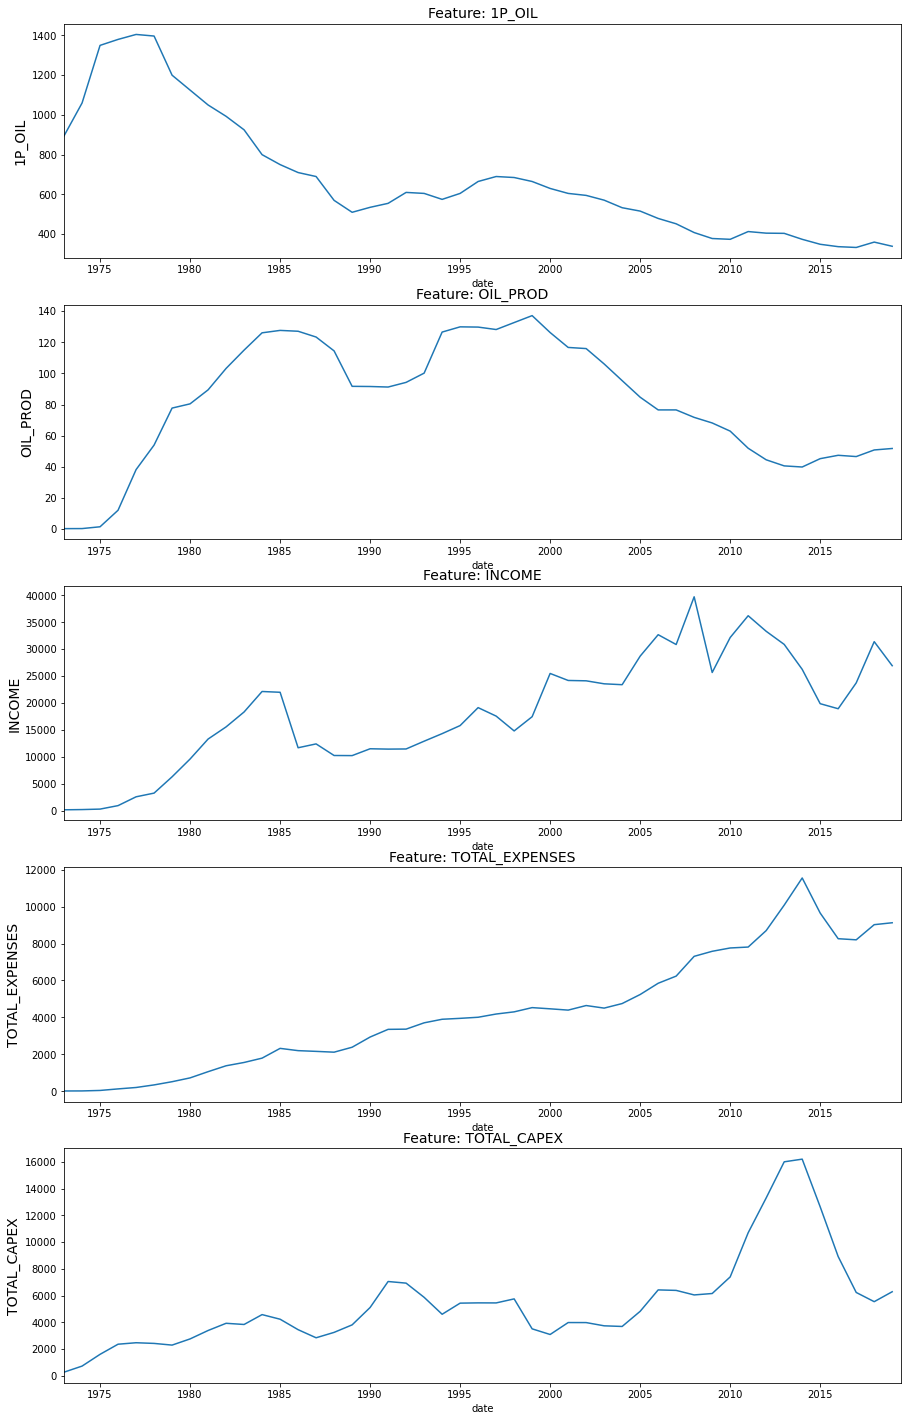

In [4]:
from datetime import date  

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i])
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)                      
    ax[i].set_xlim([date(1973, 1, 1), date(2019, 6, 30)])

plt.show()

## Verificação da propriedade de estacionariedade dos dados

### Modelos do tipo ARIMA assumem que a média e desvio padrão dos dados são estacionários. Como nenhuma das séries utilizadas neste trabalho possuem essas características, serão utilizados modelos baseados em LSTM e Prophet. Uma vez que além de não necessitarem que o dado seja estacionário eles aceitam múltiplas variáveis de entrada.

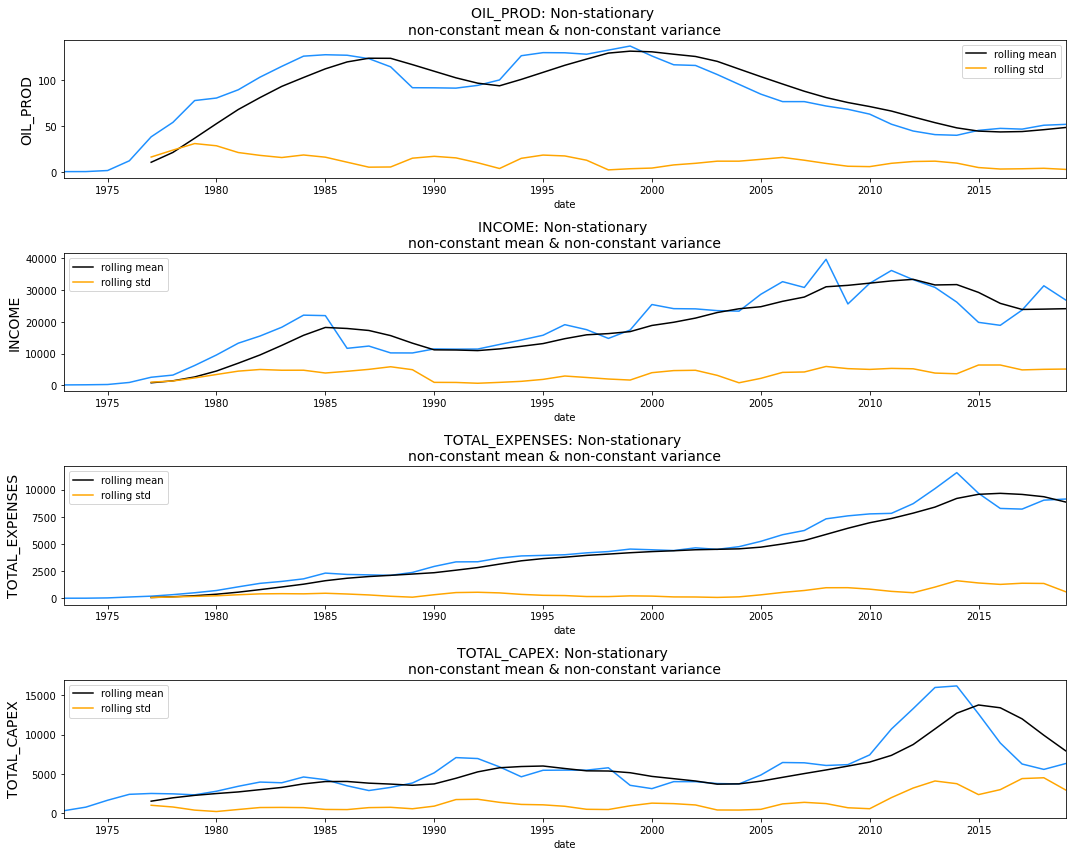

In [5]:
rolling_window = 5
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['OIL_PROD'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['OIL_PROD'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['OIL_PROD'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('OIL_PROD: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='OIL_PROD', fontsize=14)
ax[0].set_xlim([date(1973, 1, 1), date(2019, 1, 1)])

sns.lineplot(x=df['date'], y=df['INCOME'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['INCOME'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['INCOME'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('INCOME: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1].set_ylabel(ylabel='INCOME', fontsize=14)
ax[1].set_xlim([date(1973, 1, 1), date(2019, 1, 1)])

sns.lineplot(x=df['date'], y=df['TOTAL_EXPENSES'], ax=ax[2], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['TOTAL_EXPENSES'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['TOTAL_EXPENSES'].rolling(rolling_window).std(), ax=ax[2], color='orange', label='rolling std')
ax[2].set_title('TOTAL_EXPENSES: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2].set_ylabel(ylabel='TOTAL_EXPENSES', fontsize=14)
ax[2].set_xlim([date(1973, 1, 1), date(2019, 1, 1)])

sns.lineplot(x=df['date'], y=df['TOTAL_CAPEX'], ax=ax[3], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['TOTAL_CAPEX'].rolling(rolling_window).mean(), ax=ax[3], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['TOTAL_CAPEX'].rolling(rolling_window).std(), ax=ax[3], color='orange', label='rolling std')
ax[3].set_title('TOTAL_CAPEX: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[3].set_ylabel(ylabel='TOTAL_CAPEX', fontsize=14)
ax[3].set_xlim([date(1973, 1, 1), date(2019, 1, 1)])

plt.tight_layout()
plt.show()


## Augmented Dickey-Fuller (ADF) 

In [6]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

# Hipótese nula (H0): a série temporal não é estacionária.
# p-value (0.421939) não é menor que  0.05. nesse caso, não conseguimos rejeitar a hipótese nula

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['1P_OIL'].values)
result

(-1.7178507668005123,
 0.421939485523596,
 1,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 355.5790359044494)

## Matriz de Correlação

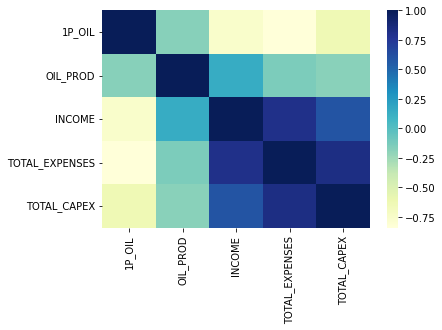

In [7]:
corrmat = df.corr()
ax = sns.heatmap(corrmat, cmap="YlGnBu")
plt.show()

# LSTM Multivariate

## Métodos auxiliares

In [8]:
from math import sqrt
from keras.layers import LSTM, Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from matplotlib import pyplot
from numpy import concatenate
from pandas import DataFrame, concat, read_csv
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Using TensorFlow backend.


In [9]:
# método series_to_supervised obtido de: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
def evaluate_model(model, history, test_X, test_y, n_time_steps, n_features):
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_time_steps*n_features))
    # invert scaling for forecast    
    inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]    
    score_mae = mean_absolute_error(inv_y, inv_yhat)
    score_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

    import matplotlib.pyplot as plt
    plt.plot(inv_y, color='red', label='Real')
    plt.plot(inv_yhat, color='blue', label='Previsto')
    plt.title(f'Previsão de série temporal - Reservas Provadas (1P) \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
    plt.xlabel('Tempo')
    plt.ylabel('1P')
    plt.legend()
    plt.show()

In [11]:
def run_network_v1(train_X, train_y, test_X, test_y, n_time_steps, n_features):
    # design network v1
    model1 = Sequential()
    # LSTM layer 1
    model1.add(LSTM(20, input_shape=(
        train_X.shape[1], train_X.shape[2])))  # 50
    # Output Layer
    model1.add(Dense(1))
    # Compile Network
    model1.compile(loss='mae', optimizer='adam')
    # Evaluate Model
    model1.summary()
    history1 = model1.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(
        test_X, test_y), verbose=0, shuffle=False)
    evaluate_model(model1, history1, test_X, test_y, n_time_steps, n_features)


In [12]:
def run_network_v2(train_X, train_y, test_X, test_y, n_time_steps, n_features):
    # design network v1.1
    model1 = Sequential()
    # LSTM layer 1
    model1.add(LSTM(20, input_shape=(
        train_X.shape[1], train_X.shape[2])))  # 50
    # Dense Layer
    model1.add(Dense(5))
    # Output Layer
    model1.add(Dense(1))
    # Compile Network
    model1.compile(loss='mae', optimizer='adam')
    # Evaluate Model
    model1.summary()
    history1 = model1.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(
        test_X, test_y), verbose=0, shuffle=False)
    evaluate_model(model1, history1, test_X, test_y, n_time_steps, n_features)

In [13]:
def run_network_v3(train_X, train_y, test_X, test_y, n_time_steps, n_features):
    # Design network v2
    model2 = Sequential()
    # LSTM layer 1
    model2.add(LSTM(units=20, return_sequences=True, input_shape=(
        train_X.shape[1], train_X.shape[2])))  # 50
    model2.add(Dropout(0.2))
    # LSTM layer 2
    model2.add(LSTM(units=10, return_sequences=True))  # 30
    model2.add(Dropout(0.2))
    # LSTM layer 3
    model2.add(LSTM(units=20, return_sequences=False))  # 50
    model2.add(Dropout(0.2))
    # Output Layer
    model2.add(Dense(units=1))
    # Compile Network
    model2.compile(optimizer='adam', loss='mae')
    # Evaluate Model
    model2.summary()
    history2 = model2.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(
        test_X, test_y), verbose=0, shuffle=False)
    evaluate_model(model2, history2, test_X, test_y, n_time_steps, n_features)

In [14]:
def run_network_v4(train_X, train_y, test_X, test_y, n_time_steps, n_features):
    # Design network v3
    model3 = Sequential()
    # LSTM layer 1
    model3.add(LSTM(units=20, return_sequences=True,
               input_shape=(train_X.shape[1], train_X.shape[2])))
    # LSTM layer 2
    model3.add(LSTM(units=20, return_sequences=False))
    # Output Layer
    model3.add(Dense(units=1))
    # Compile Network
    model3.compile(optimizer='adam', loss='mae')
    # Evaluate Model
    model3.summary()
    history3 = model3.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(
        test_X, test_y), verbose=0, shuffle=False)
    evaluate_model(model3, history3, test_X, test_y, n_time_steps, n_features)

In [15]:
def run_network_v5(train_X, train_y, test_X, test_y, n_time_steps, n_features):
    # Design network v4
    model4 = Sequential()
    # LSTM layer 1
    model4.add(LSTM(units=20, return_sequences=True,
               input_shape=(train_X.shape[1], train_X.shape[2])))
    # LSTM layer 2
    model4.add(LSTM(units=20, return_sequences=False))
    # Dense Layer
    model4.add(Dense(units=10))
    # Output Layer
    model4.add(Dense(units=1))
    # Compile Network
    model4.compile(optimizer='adam', loss='mae')
    # Evaluate Model
    model4.summary()
    history4 = model4.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(
        test_X, test_y), verbose=0, shuffle=False)
    evaluate_model(model4, history4, test_X, test_y, n_time_steps, n_features)

In [16]:
def run_network_v6(train_X, train_y, test_X, test_y, n_time_steps, n_features):
    # Design network v4
    model5 = Sequential()
    # LSTM layer 1
    model5.add(LSTM(units=128, return_sequences=True,
               input_shape=(train_X.shape[1], train_X.shape[2])))
    # LSTM layer 2
    model5.add(LSTM(units=64, return_sequences=False))
    # Dense Layer
    model5.add(Dense(units=25))
    # Output Layer
    model5.add(Dense(units=1))
    # Compile Network
    model5.compile(optimizer='adam', loss='mae')
    # Evaluate Model
    model5.summary()
    history5 = model5.fit(train_X, train_y, epochs=5, batch_size=5, validation_data=(
        test_X, test_y), verbose=0, shuffle=False)
    evaluate_model(model5, history5, test_X, test_y, n_time_steps, n_features)

In [17]:
# load dataset
dataset1P = read_csv('dataset_csv.csv', header=0, index_col=0)
dataset1P.drop(dataset1P.columns[[1, 2]], axis=1,
               inplace=True)  # remove 2P_OIL,3P_OIL
values = dataset1P.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = 5
split_proportion = 0.7

In [18]:
dataset1P.head()

,1P_OIL,OIL_PROD,INCOME,TOTAL_EXPENSES,TOTAL_CAPEX
date,,,,,
01/01/1973 00:00,895,0.372,146.300,17.60,284.00
01/01/1974 00:00,1060,0.410,190.200,20.30,736.70
01/01/1975 00:00,1350,1.564,277.400,46.30,1615.50
01/01/1976 00:00,1380,12.169,924.310,129.82,2371.64
01/01/1977 00:00,1405,38.265,2562.488,206.53,2481.51


## LSTM Multivariate (window t-2)

In [19]:
# for t-2
n_time_steps = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_time_steps, 1)
print(reframed.shape)

(45, 15)


In [20]:
reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
2,0.524254,0.000000,0.000000,0.000000,0.000000,0.678172,0.000278,0.001109,0.000234,0.028443,0.948694,0.008718,0.003312,0.002489,0.083658
3,0.678172,0.000278,0.001109,0.000234,0.028443,0.948694,0.008718,0.003312,0.002489,0.083658,0.976679,0.086281,0.019653,0.009731,0.131166
4,0.948694,0.008718,0.003312,0.002489,0.083658,0.976679,0.086281,0.019653,0.009731,0.131166,1.000000,0.277143,0.061035,0.016383,0.138069
5,0.976679,0.086281,0.019653,0.009731,0.131166,1.000000,0.277143,0.061035,0.016383,0.138069,0.992537,0.392271,0.078396,0.028469,0.134912
6,1.000000,0.277143,0.061035,0.016383,0.138069,0.992537,0.392271,0.078396,0.028469,0.134912,0.808769,0.565916,0.154850,0.043507,0.126977


In [21]:
# split into train and test sets
values = reframed.values
n_train_years = int(values.shape[0] * split_proportion)
train = values[:n_train_years, :]
test = values[n_train_years:, :]
# split into input and outputs
n_obs = n_time_steps * n_features
# var1=1P_OIL,var2=OIL_PROD,var3=INCOME,var4=TOTAL_EXPENSES,var5=TOTAL_CAPEX
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_time_steps,  n_features))
test_X = test_X.reshape((test_X.shape[0], n_time_steps,  n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(31, 2, 5) (31,) (14, 2, 5) (14,)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


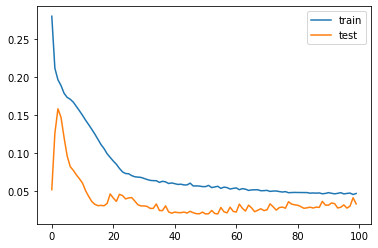

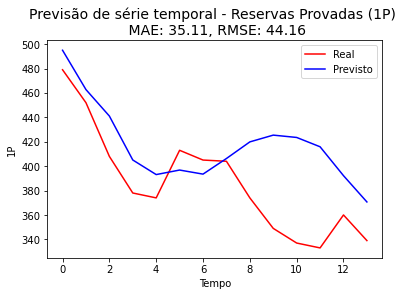

In [22]:
run_network_v1(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 2,191
Trainable params: 2,191
Non-trainable params: 0
_________________________________________________________________


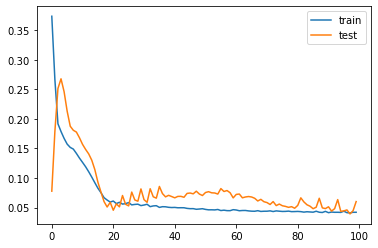

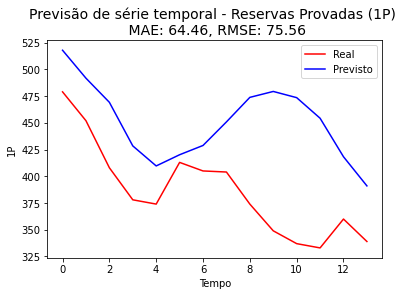

In [23]:
run_network_v2(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 2, 20)             2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 20)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 10)             1240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

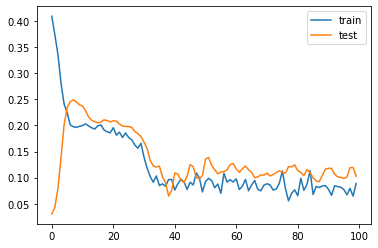

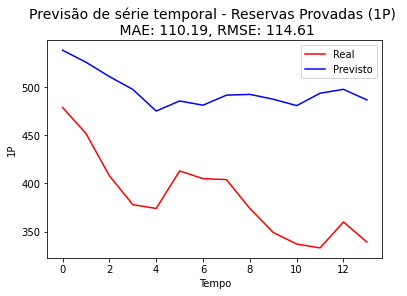

In [24]:
run_network_v3(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 2, 20)             2080      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________


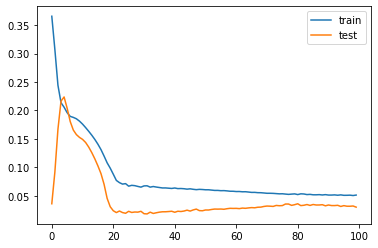

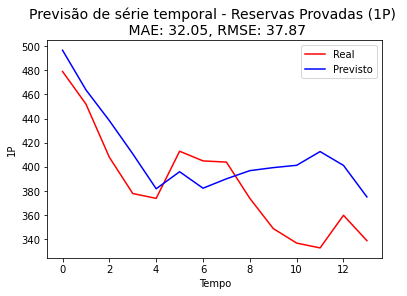

In [25]:
run_network_v4(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 2, 20)             2080      
_________________________________________________________________
lstm_9 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 5,581
Trainable params: 5,581
Non-trainable params: 0
_________________________________________________________________


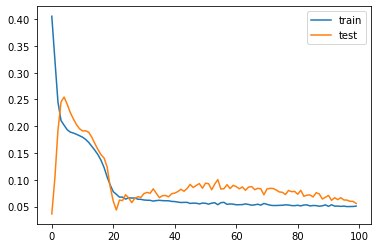

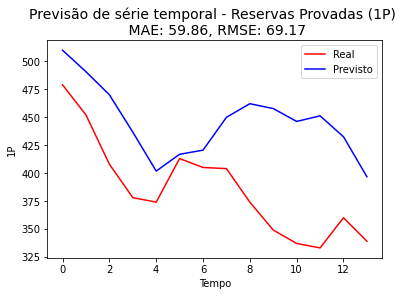

In [26]:
run_network_v5(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 2, 128)            68608     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 119,667
Trainable params: 119,667
Non-trainable params: 0
_________________________________________________________________


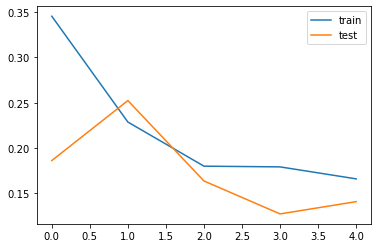

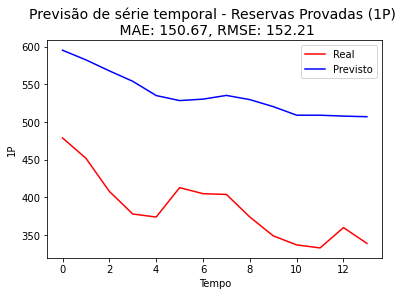

In [27]:
run_network_v6(train_X, train_y, test_X, test_y, n_time_steps, n_features)

## LSTM Multivariate (window t-1)

In [28]:
# for t-1
n_time_steps = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_time_steps, 1)
print(reframed.shape)
# split into train and test sets
values = reframed.values
n_train_years = int(values.shape[0] * split_proportion)
train = values[:n_train_years, :]
test = values[n_train_years:, :]
# split into input and outputs
n_obs = n_time_steps * n_features
# var1=1P_OIL,var2=OIL_PROD,var3=INCOME,var4=TOTAL_EXPENSES,var5=TOTAL_CAPEX
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_time_steps,  n_features))
test_X = test_X.reshape((test_X.shape[0], n_time_steps,  n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(46, 10)
(32, 1, 5) (32,) (14, 1, 5) (14,)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


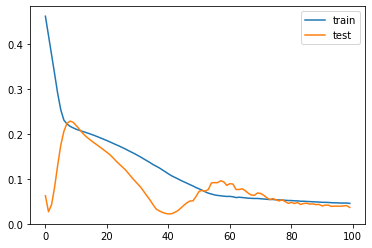

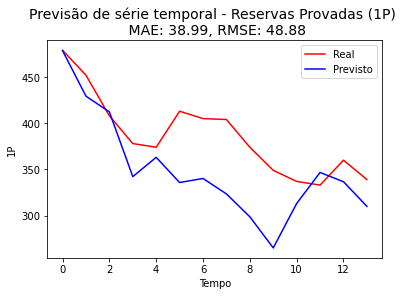

In [29]:
run_network_v1(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 20)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 2,191
Trainable params: 2,191
Non-trainable params: 0
_________________________________________________________________


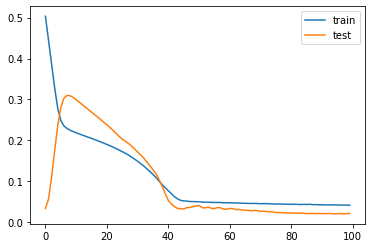

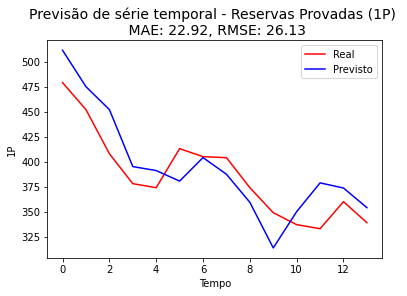

In [30]:
run_network_v2(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 20)             2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 10)             1240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

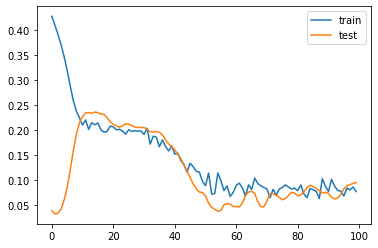

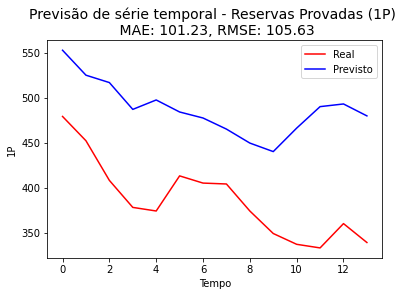

In [31]:
run_network_v3(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 20)             2080      
_________________________________________________________________
lstm_18 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________


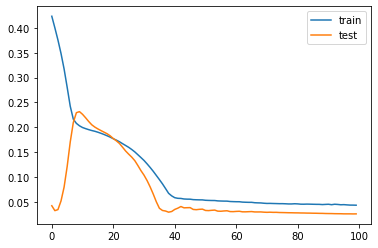

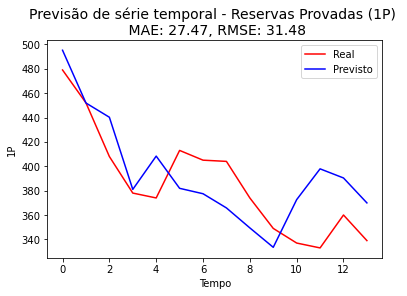

In [32]:
run_network_v4(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 1, 20)             2080      
_________________________________________________________________
lstm_20 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 5,581
Trainable params: 5,581
Non-trainable params: 0
_________________________________________________________________


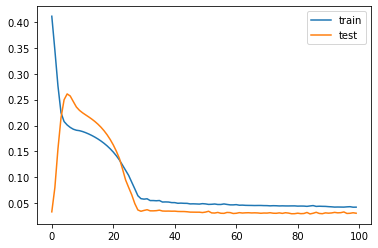

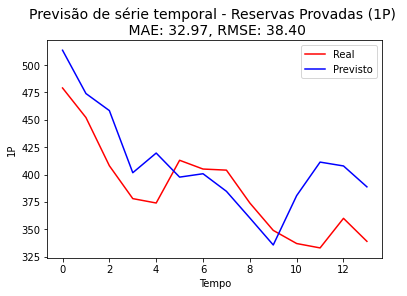

In [33]:
run_network_v5(train_X, train_y, test_X, test_y, n_time_steps, n_features)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 128)            68608     
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_17 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 26        
Total params: 119,667
Trainable params: 119,667
Non-trainable params: 0
_________________________________________________________________


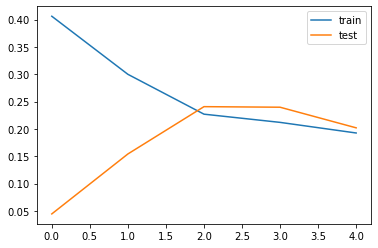

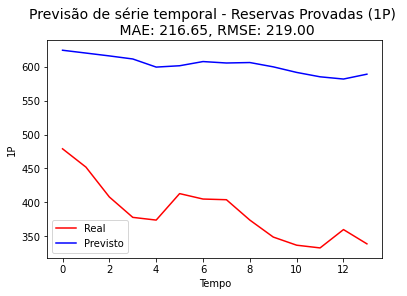

In [34]:
run_network_v6(train_X, train_y, test_X, test_y, n_time_steps, n_features)

# LSTM Univariate

## LSTM Univariate (window t-1)

(46, 2)
(32, 1, 1) (32,) (14, 1, 1) (14,)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


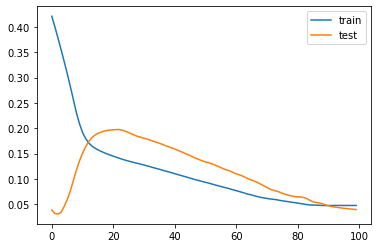

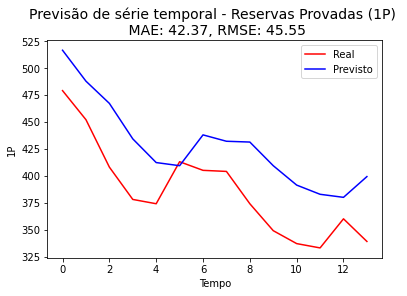

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


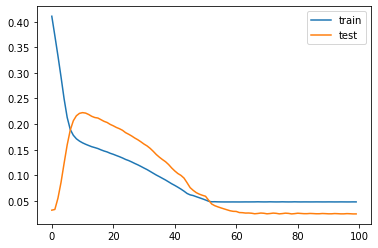

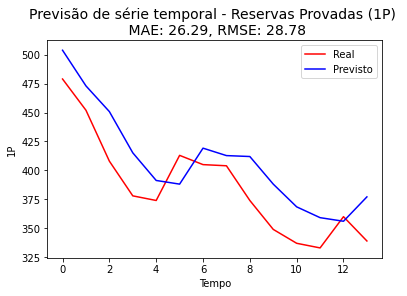

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 1, 20)             1760      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 1, 10)             1240      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)               

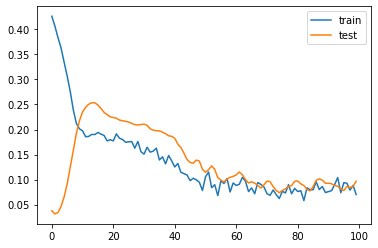

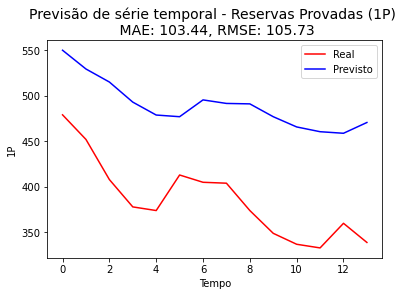

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 1, 20)             1760      
_________________________________________________________________
lstm_29 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


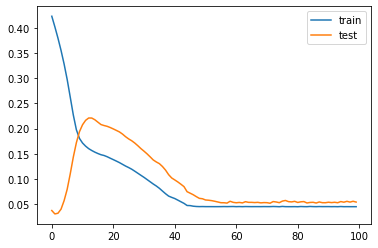

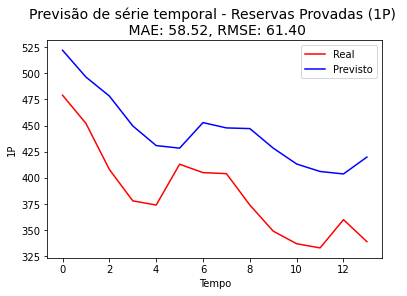

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 20)             1760      
_________________________________________________________________
lstm_31 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 11        
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


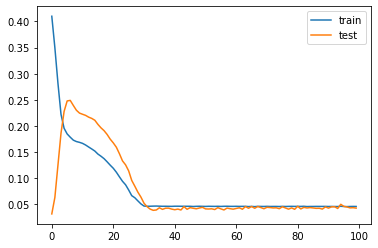

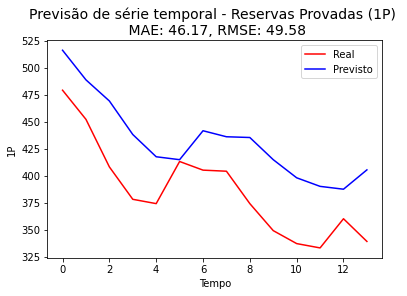

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 1, 128)            66560     
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_26 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


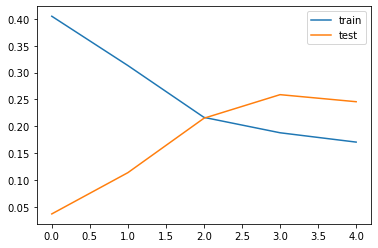

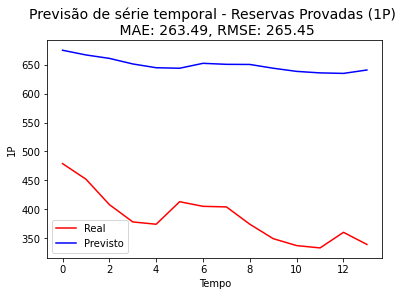

In [35]:
# load dataset
dataset1PUnivariate = read_csv('dataset_csv.csv', header=0, index_col=0)
dataset1PUnivariate.drop(dataset1PUnivariate.columns[[1, 2]], axis=1,
               inplace=True)  # remove 2P_OIL,3P_OIL
values = dataset1PUnivariate[['1P_OIL']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = 1
split_proportion = 0.7

# for t-1
n_time_steps = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_time_steps, 1)
print(reframed.shape)
# split into train and test sets
values = reframed.values
n_train_years = int(values.shape[0] * split_proportion)
train = values[:n_train_years, :]
test = values[n_train_years:, :]

#
train_ticks = dataset1PUnivariate.index[:n_train_years]
test_ticks = dataset1PUnivariate.index[n_train_years:]

# split into input and outputs
n_obs = n_time_steps * n_features
# var1=1P_OIL,var2=OIL_PROD,var3=INCOME,var4=TOTAL_EXPENSES,var5=TOTAL_CAPEX
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_time_steps,  n_features))
test_X = test_X.reshape((test_X.shape[0], n_time_steps,  n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
run_network_v1(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v2(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v3(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v4(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v5(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v6(train_X, train_y, test_X, test_y, n_time_steps, n_features)

## LSTM Univariate (window t-2)

(45, 3)
(31, 2, 1) (31,) (14, 2, 1) (14,)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


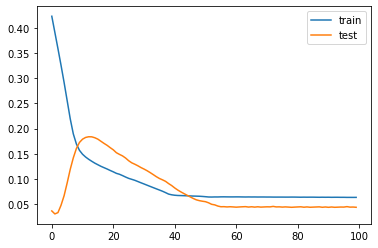

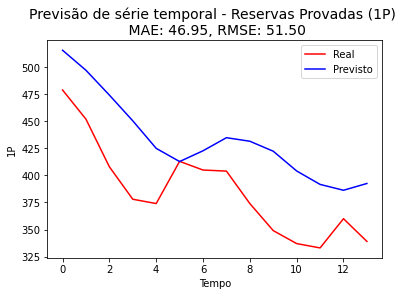

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


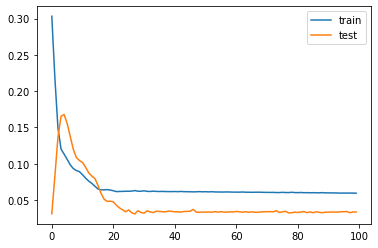

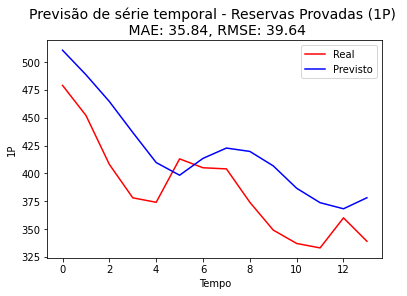

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 2, 20)             1760      
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 20)             0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 2, 10)             1240      
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 10)             0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dropout_12 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

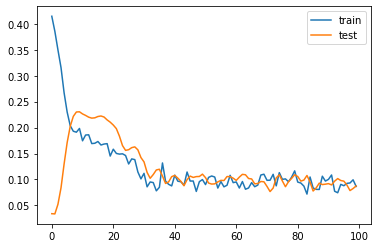

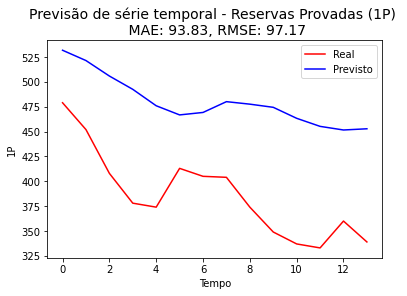

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 2, 20)             1760      
_________________________________________________________________
lstm_40 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


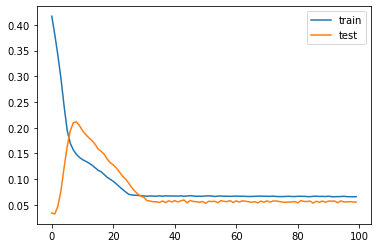

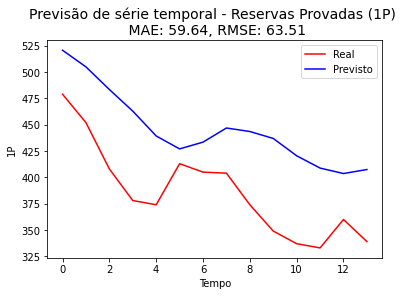

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 2, 20)             1760      
_________________________________________________________________
lstm_42 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_33 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 11        
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


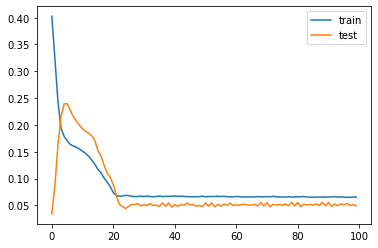

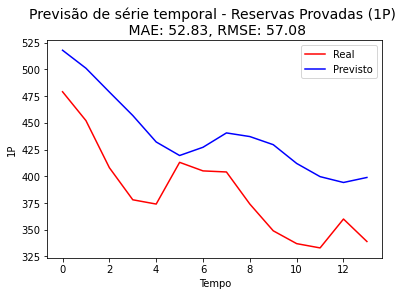

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 2, 128)            66560     
_________________________________________________________________
lstm_44 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_35 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


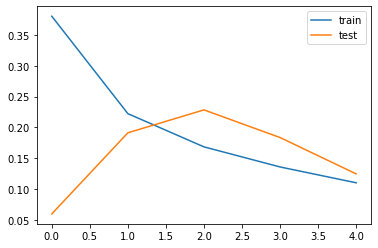

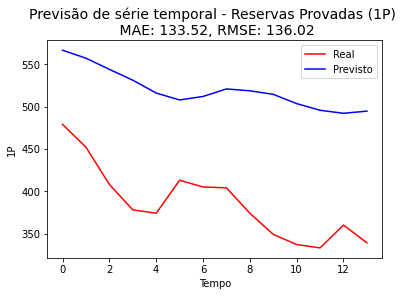

In [36]:
# load dataset
dataset1PUnivariate = read_csv('dataset_csv.csv', header=0, index_col=0)
dataset1PUnivariate.drop(dataset1PUnivariate.columns[[1, 2]], axis=1,
               inplace=True)  # remove 2P_OIL,3P_OIL
values = dataset1PUnivariate[['1P_OIL']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = 1
split_proportion = 0.7

# for t-2
n_time_steps = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_time_steps, 1)
print(reframed.shape)
# split into train and test sets
values = reframed.values
n_train_years = int(values.shape[0] * split_proportion)
train = values[:n_train_years, :]
test = values[n_train_years:, :]

#
train_ticks = dataset1PUnivariate.index[:n_train_years]
test_ticks = dataset1PUnivariate.index[n_train_years:]

# split into input and outputs
n_obs = n_time_steps * n_features
# var1=1P_OIL,var2=OIL_PROD,var3=INCOME,var4=TOTAL_EXPENSES,var5=TOTAL_CAPEX
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_time_steps,  n_features))
test_X = test_X.reshape((test_X.shape[0], n_time_steps,  n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
run_network_v1(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v2(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v3(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v4(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v5(train_X, train_y, test_X, test_y, n_time_steps, n_features)
run_network_v6(train_X, train_y, test_X, test_y, n_time_steps, n_features)

# Prophet Multivariate

In [37]:
from fbprophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from datetime import datetime, date 
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# load dataset
df = pd.read_csv('dataset_csv.csv')
df.drop(df.columns[[2, 3]], axis=1, inplace=True)
df.head()

,date,1P_OIL,OIL_PROD,INCOME,TOTAL_EXPENSES,TOTAL_CAPEX
0,01/01/1973 00:00,895,0.372,146.300,17.60,284.00
1,01/01/1974 00:00,1060,0.410,190.200,20.30,736.70
2,01/01/1975 00:00,1350,1.564,277.400,46.30,1615.50
3,01/01/1976 00:00,1380,12.169,924.310,129.82,2371.64
4,01/01/1977 00:00,1405,38.265,2562.488,206.53,2481.51


In [39]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})
feature_columns = ['OIL_PROD','INCOME','TOTAL_EXPENSES','TOTAL_CAPEX']
target_column = ['1P_OIL']

In [40]:
train_size = int(0.7 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,OIL_PROD,INCOME,TOTAL_EXPENSES,TOTAL_CAPEX
0,1973-01-01,895,0.372,146.300,17.60,284.00
1,1974-01-01,1060,0.410,190.200,20.30,736.70
2,1975-01-01,1350,1.564,277.400,46.30,1615.50
3,1976-01-01,1380,12.169,924.310,129.82,2371.64
4,1977-01-01,1405,38.265,2562.488,206.53,2481.51


In [41]:
# Train the model
model = Prophet()
model.add_regressor('OIL_PROD')
model.add_regressor('INCOME')
model.add_regressor('TOTAL_EXPENSES')
model.add_regressor('TOTAL_CAPEX')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print( 'RMSE: {}'.format(score_rmse))

C:\Users\robso\Anaconda3\envs\tf_gpu\lib\site-packages\Cython\Distutils\old_build_ext.py:41: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


RMSE: 557.555241256072


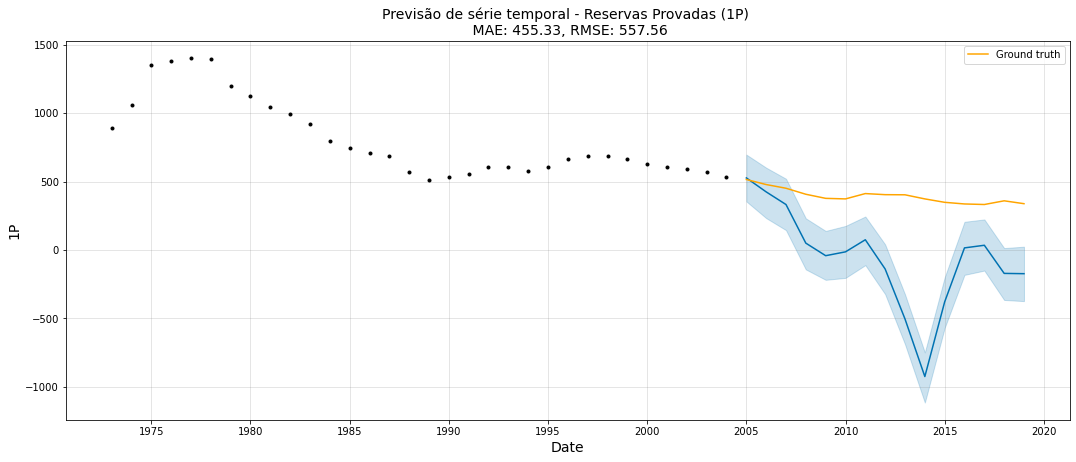

In [42]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Previsão de série temporal - Reservas Provadas (1P) \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='1P', fontsize=14)

plt.show()

# Prophet Univariate

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


32 15
RMSE: 183.353951854765


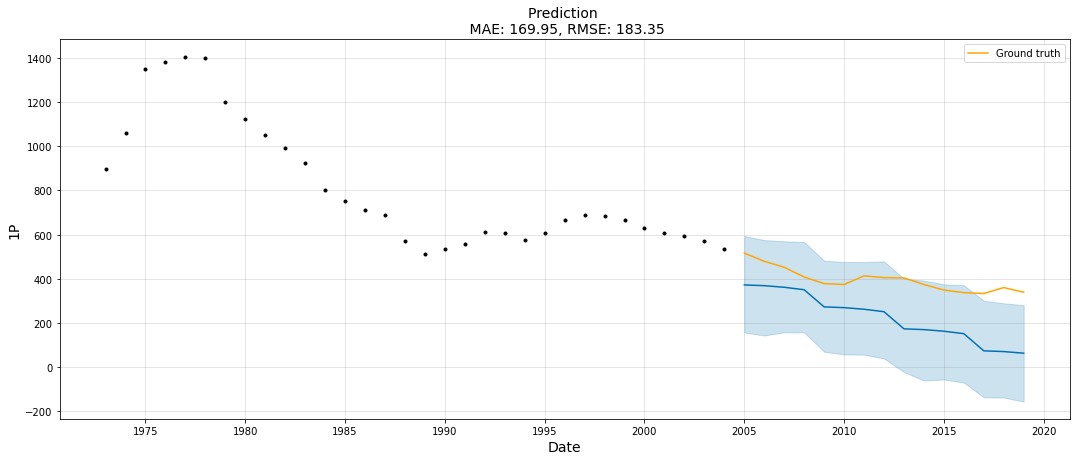

In [43]:
train_size = int(0.70 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', '1P_OIL']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='1P', fontsize=14)

plt.show()